# 멀티 에이전트 만들기

이 튜토리얼에서는 애플리케이션을 더 작고 독립적인 에이전트로 분할합니다. 이러한 접근 방식은 모듈성, 전문성, 그리고 제어 기능을 제공합니다. 개별 에이전트를 개별적으로 처리하고, 전문가 에이전트를 생성하고, 에이전트 간의 통신 방식을 제어할 수 있습니다.

지금부터는 LangGraph를 사용하여 완전한 다중 에이전트 시스템을 처음부터 구축하는 방법을 알아보겠습니다. 여기에는 다른 전문 에이전트와 통신할 수 있는 슈퍼바이저 에이전트가 있습니다. 각 에이전트는 고유한 도구 세트를 가지고 있습니다.

<img src="https://cdn.hashnode.com/res/hashnode/image/upload/v1735243479772/e2c48b8a-4992-42af-b2ec-3d045082d794.png?auto=compress,format&format=webp" />

## 1. 환경설정

In [234]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_openai langchain_experimental langchain-chroma pypdf sentence-transformers

In [235]:
import getpass
import os
from dotenv import load_dotenv
load_dotenv(override=True)

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")
_set_env("OPENAI_API_KEY")

## 2. LLM 객체 생성

In [236]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o-mini")

## 3. 웹검색 도구

In [237]:
%pip install -qU langchain-tavily

Note: you may need to restart the kernel to use updated packages.


In [238]:
from langchain_tavily import TavilySearch

web_search_tool = TavilySearch(max_results=2)

## 4. Agentic RAG 도구

In [239]:
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from langchain_core.documents import Document

def load_documents(folder_path: str) -> list[Document]:
    documents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        elif filename.endswith('.docx'):
            loader = Docx2txtLoader(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue
        documents.extend(loader.load())
    return documents

folder_path = "./docs"
documents = load_documents(folder_path)
print(f"Loaded {len(documents)} documents from the folder.")

Loaded 28 documents from the folder.


In [240]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
     chunk_size=1000,
     chunk_overlap=200,
     length_function=len
 )

splits = text_splitter.split_documents(documents)
print(f"Split the documents into {len(splits)} chunks.")

Split the documents into 71 chunks.


In [241]:
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(
    model="text-embedding-3-small",  # 가격이 저렴
)

In [242]:
from langchain_chroma import Chroma

collection_name = "my_collection"
vectorstore = Chroma.from_documents(
    collection_name=collection_name,
    documents=splits,
    embedding=embedding_function,
    persist_directory="./chroma_db"
)

In [243]:
from langchain.tools import tool
from pydantic import BaseModel

class RagToolSchema(BaseModel):
    question: str

@tool(args_schema=RagToolSchema)
def retriever_tool(question):
    """사용자 질문에 답하기 위해 의미적으로 유사한 내용을 AI브리프 문서에서 검색하는 도구"""
    print("===== RETRIEVER =====")
    retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
    retriever_result = retriever.invoke(question)
    return "\n\n".join(doc.page_content for doc in retriever_results)

## 5. NL2SQL 도구

In [244]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///./db/Chinook.db")

In [245]:
import re

def clean_sql_query(text: str) -> str:
    """
    SQL 쿼리에서 코드 블록 문법, 다양한 SQL 태그, 백틱(`), 접두사, 불필요한 공백 등을 제거하여 
    핵심 SQL 쿼리만 보존한 채로 정리합니다.
    
    Args:
        text (str): 코드 블록, 태그, 백틱 등을 포함할 수 있는 원본 SQL 쿼리 문자열
    
    Returns:
        str: 정리된(cleaned) SQL 쿼리 문자열

    """
    # 1단계: 코드 블록 문법 및 SQL 관련 태그 제거
    # ```sql, ```SQL, ```SQLQuery 등 다양한 변형을 처리합니다.
    block_pattern = r"```(?:sql|SQL|SQLQuery|mysql|postgresql)?\s*(.*?)\s*```"
    text = re.sub(block_pattern, r"\1", text, flags=re.DOTALL)

    # 2단계: "SQLQuery:"와 유사한 접두사 처리
    # "SQLQuery:", "SQL Query:", "MySQL:" 등과 같은 패턴을 매칭합니다.
    prefix_pattern = r"^(?:SQL\s*Query|SQLQuery|MySQL|PostgreSQL|SQL)\s*:\s*"
    text = re.sub(prefix_pattern, "", text, flags=re.IGNORECASE)

    # 3단계: SQL문 뒤에 불필요한 텍스트가 있을 경우, 첫 번째 SQL문만 추출
    # 세미콜론(;)으로 끝나는 완전한 SQL문을 찾습니다.
    sql_statement_pattern = r"(SELECT.*?;)"
    sql_match = re.search(sql_statement_pattern, text, flags=re.IGNORECASE | re.DOTALL)
    if sql_match:
        text = sql_match.group(1)

    # 4단계: 식별자(identifier)를 감싸고 있는 백틱(`) 제거
    text = re.sub(r'`([^`]*)`', r'\1', text)

    # 5단계: 공백 정규화
    # 여러 개의 공백을 하나의 공백으로 변경합니다.
    text = re.sub(r'\s+', ' ', text)

    # 6단계: 가독성을 유지하기 위해 주요 SQL 키워드 앞에 줄바꿈을 유지합니다.
    keywords = ['SELECT', 'FROM', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY',
               'LIMIT', 'JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN',
               'OUTER JOIN', 'UNION', 'VALUES', 'INSERT', 'UPDATE', 'DELETE']

    # SQL 키워드를 대소문자 구분 없이 치환합니다.
    pattern = '|'.join(r'\b{}\b'.format(k) for k in keywords)
    text = re.sub(f'({pattern})', r'\n\1', text, flags=re.IGNORECASE)

    # 7단계: 최종 정리
    # 앞뒤의 불필요한 공백과 과도한 줄바꿈을 제거합니다.
    text = text.strip()
    text = re.sub(r'\n\s*\n', '\n', text)

    return text

In [246]:
from langchain.chains import create_sql_query_chain
from langchain_community.tools import QuerySQLDatabaseTool
from operator import itemgetter
import re
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

class SQLToolSchema(BaseModel):
    question: str

@tool(args_schema=SQLToolSchema)
def nl2sql_tool(question):
    """사용자의 질문에 답하기 위해 데이터베이스와 관련된 SQL 쿼리를 생성하고 실행하는 도구"""
    print("===== INSIDE NL2SQL TOOL =====")
    execute_query = QuerySQLDataBaseTool(db=db)
    write_query = create_sql_query_chain(llm, db)
    
    chain = (
       RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
           result=itemgetter("query") | execute_query
       )
    )
    
    response = chain.invoke({"question": question})
    return response['result']

## 6. 감독자 에이전트 생성

감독 에이전트는 여러 전문 에이전트 간의 대화 흐름을 관리합니다. 현재 요청을 어떤 에이전트가 처리해야 하는지, 그리고 작업 완료 시점을 결정합니다. 이를 구현하는 방법을 살펴보겠습니다.

In [247]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, START, END
from langgraph.types import Command

# 사용가능한 에이전트 리스트 
members = ["web_researcher", "rag", "nl2sql"]
#작업 완료를 위한 옵션으로 FINISH를 추가합니다.
# options = members + ["FINISH"]
options = members + [END]

# 슈퍼바이저 에이전트를 위한 시스템 프롬프트 
system_prompt = (
    f"당신은 다음 작업자(에이전트)들 간의 대화를 관리하는 감독자 역할을 맡고 있습니다: {members}."
    "사용자의 요청을 바탕으로, 다음에 작업을 수행할 작업자(에이전트)를 선택해서 응답하세요."
    "각 작업자(에이전트)는 하나의 작업을 수행하고 그 결과 및 상태를 응답할 것입니다."
    "모든 작업이 완료되면, `FINISH`로 응답하세요."
)

# 구조화된 출력을 위한 라우터 타입 정의
class Router(TypedDict):
    """다음에 작업을 수행할 작업자(에이전트)를 선택하세요. 더 이상 작업자(에이전트)가 필요하지 않으면 `FINISH`로 라우팅하세요."""
    # next: Literal["web_researcher", "rag", "nl2sql", "FINISH"]
    next: Literal["web_researcher", "rag", "nl2sql", END]

# 슈퍼바이저 노드 함수를 생성합니다.
def supervisor_node(state: MessagesState) -> Command[Literal["web_researcher", "rag", "nl2sql", END]]:
    messages = [
        {"role": "system", "content": system_prompt},] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    print("***** response *****" , response)
    goto = response["next"]
    print(f"Next Worker: {goto}")
    if goto == "FINISH":
        print("***** END *****")
        goto = END
    return Command(goto=goto)


슈퍼바이저 에이전트는 다음과 같이 작동합니다.

1. 현재 대화 상태를 입력으로 사용
1. 시스템 프롬프트를 사용하여 해당 역할을 이해합니다.
1. 다음에 어떤 에이전트가 행동해야 할지 결정합니다.
1. 선택한 에이전트로 흐름을 지시하는 명령을 반환합니다.

## 7. 개별 에이전트 생성
### 1. 에이전트 구현용 함수 정의

In [248]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages.base import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """작업자(에이전트)의 상태를 저장."""
    messages: Annotated[Sequence[BaseMessage], add_messages]

# 에이전트를 생성하기 위한 함수 
def create_agent(llm, tools):
    llm_with_tools = llm.bind_tools(tools)
    
    def chatbot(state: AgentState):
        return {"messages": [llm_with_tools.invoke(state["messages"])]}

    graph_builder = StateGraph(AgentState)
    graph_builder.add_node("agent", chatbot)

    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)

    graph_builder.add_conditional_edges(
        "agent",
        tools_condition,
    )
    graph_builder.add_edge("tools", "agent")
    graph_builder.set_entry_point("agent")
    return graph_builder.compile()


### 2. 웹 서치 에이전트

In [249]:
from langgraph.graph import StateGraph
from langgraph.prebuilt.tool_node import ToolNode
from langgraph.prebuilt import tools_condition

websearch_agent = create_agent(llm, [web_search_tool])

def web_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = websearch_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_researcher")
            ]
        },
        goto="supervisor",
    )

### 3. RAG 에이전트

In [250]:
from langchain_core.messages import HumanMessage, SystemMessage

rag_agent = create_agent(llm, [retriever_tool])

def rag_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = rag_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="rag")
            ]
        },
        goto="supervisor",
    )


### 4. NL2SQL 에이전트

In [251]:
nl2sql_agent = create_agent(llm, [nl2sql_tool])

def nl2sql_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = nl2sql_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="nl2sql")
            ]
        },
        goto="supervisor",
    )


## 8. 그래프 구축

내부적으로 `Command`를 사용하고 있어서, `edge` 추가는 명시적으로 하지 않는다.

In [252]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("web_researcher", web_research_node)
builder.add_node("rag", rag_node)
builder.add_node("nl2sql", nl2sql_node)
graph = builder.compile()


이를 통해 다음과 같은 완전한 다중 에이전트 시스템이 생성됩니다.

1. 감독자는 초기 요청을 받습니다.
1. 해당 전문 에이전트에게 요청을 라우팅합니다.
1. 전문 에이전트는 도구를 사용하여 요청을 처리합니다.
1. 다음 단계를 결정하기 위해 통제권이 감독자에게 반환됩니다.
1. 감독자가 작업이 완료되었다고 판단할 때까지 프로세스가 계속됩니다.

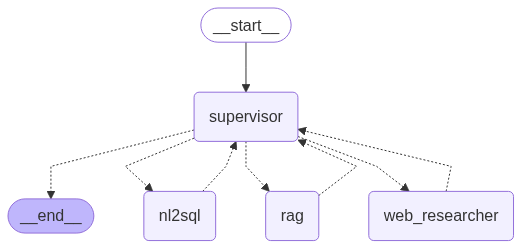

In [253]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 9. 실행

In [254]:
# Example: Complex Query Using Multiple Agents
input_question = "FutureSmart AI의 창립자를 찾은 다음, 그에 대해 웹 조사를 수행하세요."
for s in graph.stream(
    {"messages": [("user", input_question)]}, 
    subgraphs=True
):
    print(s)
    print("----")


***** response ***** {'next': 'web_researcher'}
Next Worker: web_researcher
((), {'supervisor': None})
----
(('web_researcher:bc27c0b9-269e-87fb-19b3-31c935f2b3e3',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tClZLQWRiBJXxixwml3g1JzX', 'function': {'arguments': '{"query":"FutureSmart AI 창립자","search_depth":"advanced"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 810, 'total_tokens': 836, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BpUJbdNVPYKcyS35hEsKeZb9Ab5iG', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--fbb54461-c724-4849-a86e-0cdf68844f9c-0'

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


***** response ***** {'next': 'FINISH'}
Next Worker: FINISH
***** END *****
((), {'supervisor': None})
----
